In [ ]:
import pandas as pd

# Load the data into a DataFrame
# Assuming the data is in a CSV file named 'stock_data.csv' in the current directory
# Replace 'stock_data.csv' with the actual path to your data file
try:
    full_df = pd.read_csv('stock_data.csv')
except FileNotFoundError:
    print("Error: 'stock_data.csv' not found. Please update the code with the correct file path.")

Error: 'stock_data.csv' not found. Please update the code with the correct file path.


In [ ]:
!pip install yfinance
!pip install pandas-datareader
!pip install matplotlib
!pip install numpy
!pip install sklearn
!pip install prophet
!pip install tensorflow
!pip install keras

  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.


In [ ]:
!pip install tensorflow

In [ ]:
!pip install pandas_market_calendars

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.4/127.4 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 208.9/208.9 kB 9.3 MB/s eta 0:00:00


In [ ]:
# นำเข้าไลบรารีที่จำเป็น
import yfinance as yf
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, BayesianRidge, HuberRegressor, SGDRegressor, PassiveAggressiveRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor, AdaBoostRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
import xgboost as xgb
import lightgbm as lgb
from sklearn.metrics import (
    mean_absolute_error,
    r2_score,
    mean_squared_error,  # เก็บไว้สำหรับคำนวณ RMSE
    mean_absolute_percentage_error,
    max_error,
    median_absolute_error,
    explained_variance_score
)
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns

# -----------------------------------------------------------------------------
# 1. ดาวน์โหลดข้อมูลหุ้นหลายตัว
# -----------------------------------------------------------------------------
tickers = ["AAPL", "AMD", "APP", "AVGO", "GOOG", "GOOGL", "META", "MSFT", "NVDA", "PLTR"]
start_date = datetime(2019, 1, 1)
end_date   = datetime(2024, 12, 31)

all_data_list = []
for ticker in tickers:
    print(f"📥 Downloading {ticker} ...")
    data = yf.download(ticker, start=start_date.strftime('%Y-%m-%d'), end=end_date.strftime('%Y-%m-%d'))
    if data.empty:
        print(f"❌ No data for {ticker}")
        continue
    data.reset_index(inplace=True)
    if isinstance(data.columns, pd.MultiIndex):
        data.columns = [' '.join(col).strip() if isinstance(col, tuple) else col for col in data.columns.values]

    def clean_columns(cols):
        cleaned = []
        for col in cols:
            if 'Date' in col:
                cleaned.append('Date')
            elif 'Adj Close' in col:
                cleaned.append('Adj_Close')
            else:
                cleaned.append(col.split()[0])
        return cleaned

    data.columns = clean_columns(data.columns)
    data['Symbol'] = ticker.upper()
    wanted_cols = ['Date', 'Close', 'High', 'Low', 'Open', 'Volume', 'Symbol']
    if 'Adj_Close' in data.columns:
        wanted_cols.append('Adj_Close')
    data = data[[col for col in wanted_cols if col in data.columns]]
    all_data_list.append(data)

flat_df = pd.concat(all_data_list, ignore_index=True)
flat_df['Date'] = pd.to_datetime(flat_df['Date']).dt.normalize()
flat_df['Symbol'] = flat_df['Symbol'].astype(str).str.upper()
flat_df = flat_df.sort_values(by=['Symbol', 'Date']).reset_index(drop=True)

import pandas as pd
import pandas_market_calendars as mcal

# 1. สร้างช่วงวันที่ต่อเนื่องจากข้อมูลจริง
all_dates = pd.DataFrame({
    'Date': pd.date_range(flat_df['Date'].min(), flat_df['Date'].max())
})

# 2. สร้างรายการ Symbol ให้ครบทุกวัน
symbols = flat_df['Symbol'].unique()
expanded_list = []

for sym in symbols:
    temp = all_dates.copy()
    temp['Symbol'] = sym
    expanded_list.append(temp)

# รวมข้อมูล Symbol ทั้งหมดเข้าด้วยกัน
all_dates_symbols = pd.concat(expanded_list, ignore_index=True)

# 3. รวมข้อมูลกับ flat_df (ราคาหุ้น)
full_df = all_dates_symbols.merge(flat_df, on=['Date', 'Symbol'], how='left')

# 4. เลือกเฉพาะคอลัมน์ที่ต้องการ
full_df = full_df[['Date', 'Symbol', 'Open', 'High', 'Low', 'Close']]



📥 Downloading AAPL ...


/tmp/ipython-input-2946816906.py:39: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start=start_date.strftime('%Y-%m-%d'), end=end_date.strftime('%Y-%m-%d'))
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-2946816906.py:39: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start=start_date.strftime('%Y-%m-%d'), end=end_date.strftime('%Y-%m-%d'))


📥 Downloading AMD ...


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-2946816906.py:39: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start=start_date.strftime('%Y-%m-%d'), end=end_date.strftime('%Y-%m-%d'))


📥 Downloading APP ...


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-2946816906.py:39: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start=start_date.strftime('%Y-%m-%d'), end=end_date.strftime('%Y-%m-%d'))


📥 Downloading AVGO ...


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-2946816906.py:39: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start=start_date.strftime('%Y-%m-%d'), end=end_date.strftime('%Y-%m-%d'))


📥 Downloading GOOG ...


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-2946816906.py:39: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start=start_date.strftime('%Y-%m-%d'), end=end_date.strftime('%Y-%m-%d'))


📥 Downloading GOOGL ...


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-2946816906.py:39: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start=start_date.strftime('%Y-%m-%d'), end=end_date.strftime('%Y-%m-%d'))


📥 Downloading META ...


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-2946816906.py:39: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start=start_date.strftime('%Y-%m-%d'), end=end_date.strftime('%Y-%m-%d'))


📥 Downloading MSFT ...


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-2946816906.py:39: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start=start_date.strftime('%Y-%m-%d'), end=end_date.strftime('%Y-%m-%d'))


📥 Downloading NVDA ...


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-2946816906.py:39: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start=start_date.strftime('%Y-%m-%d'), end=end_date.strftime('%Y-%m-%d'))


📥 Downloading PLTR ...


[*********************100%***********************]  1 of 1 completed


In [ ]:
# ----------------------------
# เติมค่าว่าง Close แยกแต่ละ Symbol
# ----------------------------
price_cols = ['Close','Open', 'High', 'Low', 'Close']
for col in price_cols:
    full_df[col] = full_df.groupby('Symbol')[col].transform(
        lambda x: x.interpolate(method='ffill')  # เติมค่า linear ระหว่างข้อมูล
    )

/tmp/ipython-input-3187276925.py:7: FutureWarning: Series.interpolate with method=ffill is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  lambda x: x.interpolate(method='ffill')  # เติมค่า linear ระหว่างข้อมูล
/tmp/ipython-input-3187276925.py:7: FutureWarning: Series.interpolate with method=ffill is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  lambda x: x.interpolate(method='ffill')  # เติมค่า linear ระหว่างข้อมูล
/tmp/ipython-input-3187276925.py:7: FutureWarning: Series.interpolate with method=ffill is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  lambda x: x.interpolate(method='ffill')  # เติมค่า linear ระหว่างข้อมูล
/tmp/ipython-input-3187276925.py:7: FutureWarning: Series.interpolate with method=ffill is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  lambda x: x.interpolate(method='ffill')  # เติมค่า linear ระหว่า

In [ ]:
full_df

,Date,Symbol,Open,High,Low,Close
0,2019-01-02,AAPL,36.854243,37.796480,36.697203,37.575195
1,2019-01-03,AAPL,34.258347,34.672361,33.787231,33.832439
2,2019-01-04,AAPL,34.389213,35.345726,34.215519,35.276722
3,2019-01-05,AAPL,34.389213,35.345726,34.215519,35.276722
4,2019-01-06,AAPL,34.389213,35.345726,34.215519,35.276722
...,...,...,...,...,...,...
21895,2024-12-26,PLTR,83.160004,83.489998,81.300003,82.139999
21896,2024-12-27,PLTR,81.419998,82.000000,77.930000,79.080002
21897,2024-12-28,PLTR,81.419998,82.000000,77.930000,79.080002
21898,2024-12-29,PLTR,81.419998,82.000000,77.930000,79.080002


In [ ]:
# นำเข้าไลบรารีที่จำเป็น
import yfinance as yf
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, BayesianRidge, HuberRegressor, SGDRegressor, PassiveAggressiveRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor, AdaBoostRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
import xgboost as xgb
import lightgbm as lgb
from sklearn.metrics import (
    mean_absolute_error,
    r2_score,
    mean_squared_error,  # เก็บไว้สำหรับคำนวณ RMSE
    mean_absolute_percentage_error,
    max_error,
    median_absolute_error,
    explained_variance_score
)
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns

# ------------------------------
# ติดตั้งไลบรารีที่จำเป็นเพิ่มเติม
# ------------------------------
!pip install prophet tensorflow

# ------------------------------
# นำเข้าไลบรารีเพิ่มเติม
# ------------------------------
from prophet import Prophet
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
import warnings
warnings.filterwarnings('ignore')

# ------------------------------
# 3. เตรียมข้อมูลสำหรับ Prophet
# ------------------------------
# เลือกเฉพาะข้อมูล AAPL
aapl_df = full_df[full_df['Symbol'] == 'AAPL'].copy()

# แปลงรูปแบบสำหรับ Prophet
prophet_df = aapl_df[['Date', 'Close']].rename(columns={'Date': 'ds', 'Close': 'y'})
prophet_df = prophet_df.dropna()  # ลบแถวที่มีค่า NaN

# แบ่งข้อมูลเป็น train/test (80:20)
train_size = int(len(prophet_df) * 0.8)
train_prophet = prophet_df.iloc[:train_size]
test_prophet = prophet_df.iloc[train_size:]

# ------------------------------
# 4. สร้างโมเดล Prophet และทำนายค่าเริ่มต้น
# ------------------------------
# สร้างและฝึกโมเดล Prophet
prophet_model = Prophet(
    yearly_seasonality=True,
    weekly_seasonality=True,
    daily_seasonality=False,
    seasonality_mode='additive',
    changepoint_prior_scale=0.05
)
prophet_model.fit(train_prophet)

# สร้าง DataFrame สำหรับการทำนาย
future = prophet_model.make_future_dataframe(periods=len(test_prophet))
prophet_forecast = prophet_model.predict(future)

# คำนวณค่า residual (ค่าจริง - ค่าทำนาย)
prophet_forecast['residual'] = prophet_df['y'] - prophet_forecast['yhat']

# แยก residual สำหรับ train และ test
train_residual = prophet_forecast.iloc[:train_size]['residual'].values.reshape(-1, 1)
test_residual = prophet_forecast.iloc[train_size:]['residual'].values.reshape(-1, 1)

# ------------------------------
# 5. เตรียมข้อมูลสำหรับ LSTM
# ------------------------------
# ปรับขนาดข้อมูล residual
scaler = MinMaxScaler(feature_range=(-1, 1))
train_residual_scaled = scaler.fit_transform(train_residual)
test_residual_scaled = scaler.transform(test_residual)

# สร้างลำดับข้อมูล (sequences) สำหรับ LSTM
def create_sequences(data, look_back=10):
    X, y = [], []
    for i in range(len(data) - look_back):
        X.append(data[i:i+look_back])
        y.append(data[i+look_back])
    return np.array(X), np.array(y)

look_back = 10
X_train, y_train = create_sequences(train_residual_scaled, look_back)
X_test, y_test = create_sequences(test_residual_scaled, look_back)

# ปรับรูปร่างข้อมูลสำหรับ LSTM [samples, timesteps, features]
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# ------------------------------
# 6. สร้างและฝึกโมเดล LSTM
# ------------------------------
# สร้างโมเดล LSTM
lstm_model = Sequential([
    LSTM(64, activation='relu', input_shape=(look_back, 1), return_sequences=True),
    Dropout(0.2),
    LSTM(32, activation='relu'),
    Dropout(0.2),
    Dense(1)
])

lstm_model.compile(optimizer='adam', loss='mse')

# กำหนด Early Stopping
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# ฝึกโมเดล
history = lstm_model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=16,
    validation_split=0.2,
    callbacks=[early_stop],
    verbose=1
)

# ------------------------------
# 7. ทำนายค่า residual ด้วย LSTM
# ------------------------------
# ทำนายค่า residual สำหรับข้อมูลทดสอบ
predicted_residual_scaled = lstm_model.predict(X_test)

# แปลงค่ากลับเป็นของจริง
predicted_residual = scaler.inverse_transform(predicted_residual_scaled)
# ------------------------------
# 8. รวมผลลัพธ์และประเมิน
# ------------------------------
# ค่าทำนายสุดท้าย = Prophet forecast + LSTM residual forecast
prophet_test_forecast = prophet_forecast.iloc[train_size + look_back:]['yhat'].values
final_forecast = prophet_test_forecast + predicted_residual.flatten()

# ค่าจริงสำหรับการทดสอบ
actual_values = test_prophet.iloc[look_back:]['y'].values

# คำนวณค่าความคลาดเคลื่อน
mae = mean_absolute_error(actual_values, final_forecast)
rmse = np.sqrt(mean_squared_error(actual_values, final_forecast))
mape = np.mean(np.abs((actual_values - final_forecast) / actual_values)) * 100
r2 = r2_score(actual_values, final_forecast)

print("\nผลการประเมินโมเดล Hybrid Prophet + LSTM:")
print(f"MAE: {mae:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAPE: {mape:.4f}%")
print(f"R^2: {r2:.4f}")


DEBUG:cmdstanpy:input tempfile: /tmp/tmpm2rx1nod/pjifl_dw.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpm2rx1nod/ugi78_ns.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=96077', 'data', 'file=/tmp/tmpm2rx1nod/pjifl_dw.json', 'init=/tmp/tmpm2rx1nod/ugi78_ns.json', 'output', 'file=/tmp/tmpm2rx1nod/prophet_model_2px25_u/prophet_model-20251002211214.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:12:14 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:12:15 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Epoch 1/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 6s 24ms/step - loss: 0.0490 - val_loss: 0.0276
Epoch 2/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0226 - val_loss: 0.0220
Epoch 3/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0196 - val_loss: 0.0182
Epoch 4/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0191 - val_loss: 0.0172
Epoch 5/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0175 - val_loss: 0.0163
Epoch 6/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0150 - val_loss: 0.0197
Epoch 7/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0160 - val_loss: 0.0152
Epoch 8/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0135 - val_loss: 0.0134
Epoch 9/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0135 - val_loss: 0.0139
Epoch 10/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0135 - val_loss: 0.0140
Epoch 11/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0152 - val_loss: 0.0120
Epoch 12/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step

In [ ]:
flat_df=full_df

In [ ]:
prophet_dfs = {}

for ticker in tickers:
    df_ticker = flat_df[flat_df['Symbol'] == ticker][['Date', 'Close']].copy()
    df_ticker = df_ticker.rename(columns={'Date': 'ds', 'Close': 'y'})
    df_ticker['ds'] = pd.to_datetime(df_ticker['ds'])
    df_ticker['y'] = pd.to_numeric(df_ticker['y'], errors='coerce')
    df_ticker = df_ticker.dropna()

    prophet_dfs[ticker] = df_ticker
    print(f"✅ Prepared {ticker}: {df_ticker.shape[0]} rows")


✅ Prepared AAPL: 2190 rows
✅ Prepared AMD: 2190 rows
✅ Prepared APP: 1356 rows
✅ Prepared AVGO: 2190 rows
✅ Prepared GOOG: 2190 rows
✅ Prepared GOOGL: 2190 rows
✅ Prepared META: 2190 rows
✅ Prepared MSFT: 2190 rows
✅ Prepared NVDA: 2190 rows
✅ Prepared PLTR: 1553 rows


DEBUG:cmdstanpy:input tempfile: /tmp/tmpm2rx1nod/rjj3bxmv.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpm2rx1nod/eul11yqr.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=40807', 'data', 'file=/tmp/tmpm2rx1nod/rjj3bxmv.json', 'init=/tmp/tmpm2rx1nod/eul11yqr.json', 'output', 'file=/tmp/tmpm2rx1nod/prophet_modelocw3gjea/prophet_model-20251002211304.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:13:04 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:13:07 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


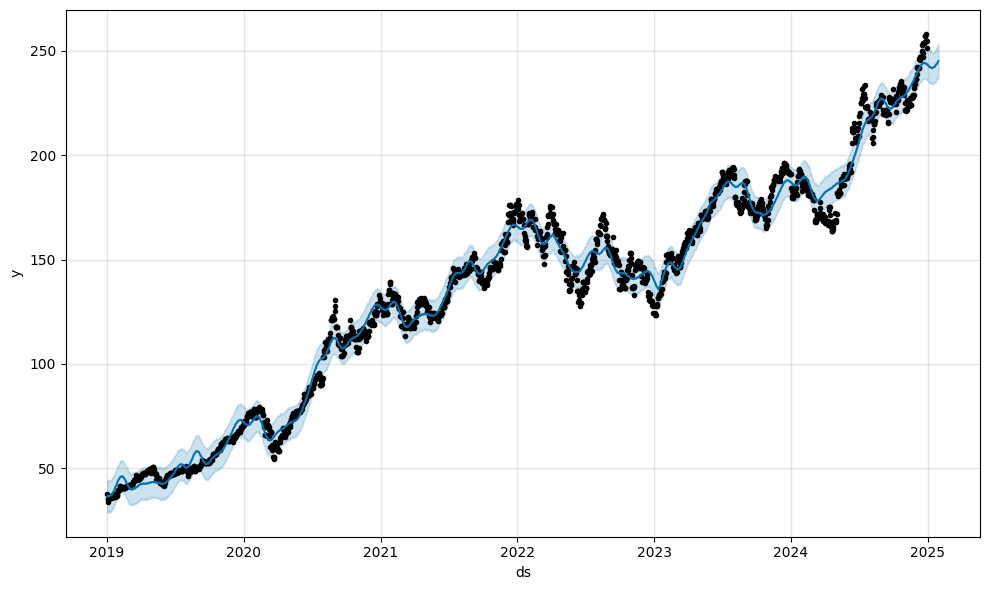

In [ ]:
from prophet import Prophet

df_aapl = prophet_dfs['AAPL']

model = Prophet(daily_seasonality=True)
model.fit(df_aapl)

future = model.make_future_dataframe(periods=30)  # 30 วันข้างหน้า
forecast = model.predict(future)

fig = model.plot(forecast)


In [ ]:
from prophet import Prophet

results = {}

# จำนวนวันที่จะพยากรณ์ล่วงหน้า
forecast_horizon = 30

for ticker in tickers:
    print(f"📊 Training Prophet for {ticker} ...")

    # เตรียมข้อมูล
    df_ticker = flat_df[flat_df['Symbol'] == ticker][['Date', 'Close']].copy()
    df_ticker = df_ticker.rename(columns={'Date': 'ds', 'Close': 'y'})
    df_ticker['ds'] = pd.to_datetime(df_ticker['ds'])
    df_ticker['y'] = pd.to_numeric(df_ticker['y'], errors='coerce')
    df_ticker = df_ticker.dropna()

    if df_ticker.empty:
        print(f"❌ Skipped {ticker}, no valid data")
        continue

    # Fit Prophet
    model = Prophet(daily_seasonality=True)
    model.fit(df_ticker)

    # Forecast
    future = model.make_future_dataframe(periods=forecast_horizon)
    forecast = model.predict(future)

    # เก็บผลลัพธ์
    results[ticker] = {
        "model": model,
        "forecast": forecast,
        "history": df_ticker
    }

    print(f"✅ Done {ticker}: forecast {forecast_horizon} days ahead")

print("\n🎯 Training & Forecasting Completed!")


DEBUG:cmdstanpy:input tempfile: /tmp/tmpm2rx1nod/xxrilfxj.json


📊 Training Prophet for AAPL ...


DEBUG:cmdstanpy:input tempfile: /tmp/tmpm2rx1nod/ycm0kcv6.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=50562', 'data', 'file=/tmp/tmpm2rx1nod/xxrilfxj.json', 'init=/tmp/tmpm2rx1nod/ycm0kcv6.json', 'output', 'file=/tmp/tmpm2rx1nod/prophet_modelc6zfvjif/prophet_model-20251002211308.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:13:08 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:13:11 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Done AAPL: forecast 30 days ahead
📊 Training Prophet for AMD ...


DEBUG:cmdstanpy:input tempfile: /tmp/tmpm2rx1nod/j4wj4mks.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpm2rx1nod/zcs_qoi6.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=21733', 'data', 'file=/tmp/tmpm2rx1nod/j4wj4mks.json', 'init=/tmp/tmpm2rx1nod/zcs_qoi6.json', 'output', 'file=/tmp/tmpm2rx1nod/prophet_model603d1_d9/prophet_model-20251002211313.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:13:13 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:13:17 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpm2rx1nod/ols_grv7.json


✅ Done AMD: forecast 30 days ahead
📊 Training Prophet for APP ...


DEBUG:cmdstanpy:input tempfile: /tmp/tmpm2rx1nod/l_dyzzr6.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=55307', 'data', 'file=/tmp/tmpm2rx1nod/ols_grv7.json', 'init=/tmp/tmpm2rx1nod/l_dyzzr6.json', 'output', 'file=/tmp/tmpm2rx1nod/prophet_model2b2w8e1f/prophet_model-20251002211318.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:13:18 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:13:19 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpm2rx1nod/i2tsprem.json


✅ Done APP: forecast 30 days ahead
📊 Training Prophet for AVGO ...


DEBUG:cmdstanpy:input tempfile: /tmp/tmpm2rx1nod/1oqkteri.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=82685', 'data', 'file=/tmp/tmpm2rx1nod/i2tsprem.json', 'init=/tmp/tmpm2rx1nod/1oqkteri.json', 'output', 'file=/tmp/tmpm2rx1nod/prophet_modelyikjllt1/prophet_model-20251002211320.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:13:20 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:13:23 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpm2rx1nod/iaz3li9i.json


✅ Done AVGO: forecast 30 days ahead
📊 Training Prophet for GOOG ...


DEBUG:cmdstanpy:input tempfile: /tmp/tmpm2rx1nod/05rz1jh2.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=55494', 'data', 'file=/tmp/tmpm2rx1nod/iaz3li9i.json', 'init=/tmp/tmpm2rx1nod/05rz1jh2.json', 'output', 'file=/tmp/tmpm2rx1nod/prophet_modeliog_i08m/prophet_model-20251002211324.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:13:24 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:13:29 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpm2rx1nod/ll0jl_z2.json


✅ Done GOOG: forecast 30 days ahead
📊 Training Prophet for GOOGL ...


DEBUG:cmdstanpy:input tempfile: /tmp/tmpm2rx1nod/awarki48.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=19540', 'data', 'file=/tmp/tmpm2rx1nod/ll0jl_z2.json', 'init=/tmp/tmpm2rx1nod/awarki48.json', 'output', 'file=/tmp/tmpm2rx1nod/prophet_modelsver3_s3/prophet_model-20251002211330.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:13:30 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:13:32 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpm2rx1nod/0w5fqbyd.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpm2rx1nod/9ubwg4zm.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.b

✅ Done GOOGL: forecast 30 days ahead
📊 Training Prophet for META ...


21:13:34 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpm2rx1nod/llqu1tx5.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpm2rx1nod/i1cvvjpc.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=73016', 'data', 'file=/tmp/tmpm2rx1nod/llqu1tx5.json', 'init=/tmp/tmpm2rx1nod/i1cvvjpc.json', 'output', 'file=/tmp/tmpm2rx1nod/prophet_modeld_oozvnr/prophet_model-20251002211334.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:13:34 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


✅ Done META: forecast 30 days ahead
📊 Training Prophet for MSFT ...


21:13:36 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpm2rx1nod/9rcrvwco.json


✅ Done MSFT: forecast 30 days ahead
📊 Training Prophet for NVDA ...


DEBUG:cmdstanpy:input tempfile: /tmp/tmpm2rx1nod/fzs19o8b.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=98738', 'data', 'file=/tmp/tmpm2rx1nod/9rcrvwco.json', 'init=/tmp/tmpm2rx1nod/fzs19o8b.json', 'output', 'file=/tmp/tmpm2rx1nod/prophet_modelqkkdj_0i/prophet_model-20251002211337.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:13:37 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:13:38 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpm2rx1nod/sln53ahh.json


✅ Done NVDA: forecast 30 days ahead
📊 Training Prophet for PLTR ...


DEBUG:cmdstanpy:input tempfile: /tmp/tmpm2rx1nod/kwpk031y.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=78052', 'data', 'file=/tmp/tmpm2rx1nod/sln53ahh.json', 'init=/tmp/tmpm2rx1nod/kwpk031y.json', 'output', 'file=/tmp/tmpm2rx1nod/prophet_modelvubb27bf/prophet_model-20251002211339.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:13:39 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:13:41 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Done PLTR: forecast 30 days ahead

🎯 Training & Forecasting Completed!


In [ ]:
results['AAPL']['forecast'].tail()


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
2215,2025-01-25,245.448217,236.694797,251.245935,245.310401,245.503024,-1.552560,-1.552560,-1.552560,-6.283979,...,-0.066321,-0.066321,-0.066321,4.797740,4.797740,4.797740,0.0,0.0,0.0,243.895657
2216,2025-01-26,245.602216,236.736579,251.435442,245.442227,245.699193,-1.529756,-1.529756,-1.529756,-6.283979,...,-0.160680,-0.160680,-0.160680,4.914903,4.914903,4.914903,0.0,0.0,0.0,244.072460
2217,2025-01-27,245.756215,236.679170,251.949433,245.526411,245.972612,-1.232958,-1.232958,-1.232958,-6.283979,...,0.022469,0.022469,0.022469,5.028553,5.028553,5.028553,0.0,0.0,0.0,244.523257
2218,2025-01-28,245.910214,237.306517,252.318326,245.650488,246.206457,-1.063036,-1.063036,-1.063036,-6.283979,...,0.086846,0.086846,0.086846,5.134098,5.134098,5.134098,0.0,0.0,0.0,244.847178
2219,2025-01-29,246.064213,237.026932,252.723064,245.776744,246.413007,-0.959427,-0.959427,-0.959427,-6.283979,...,0.097614,0.097614,0.097614,5.226938,5.226938,5.226938,0.0,0.0,0.0,245.104786


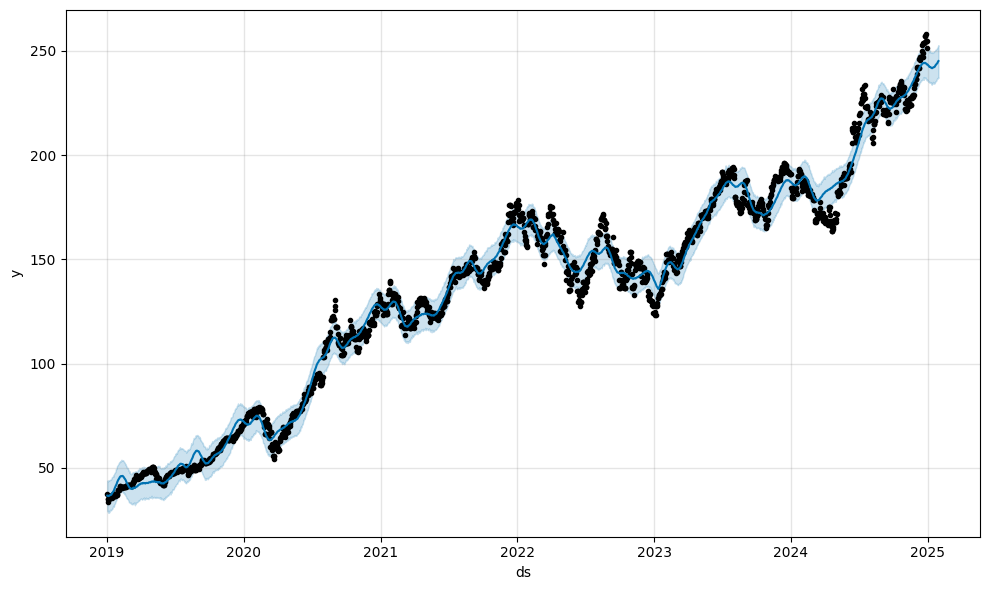

In [ ]:
fig = results['AAPL']['model'].plot(results['AAPL']['forecast'])


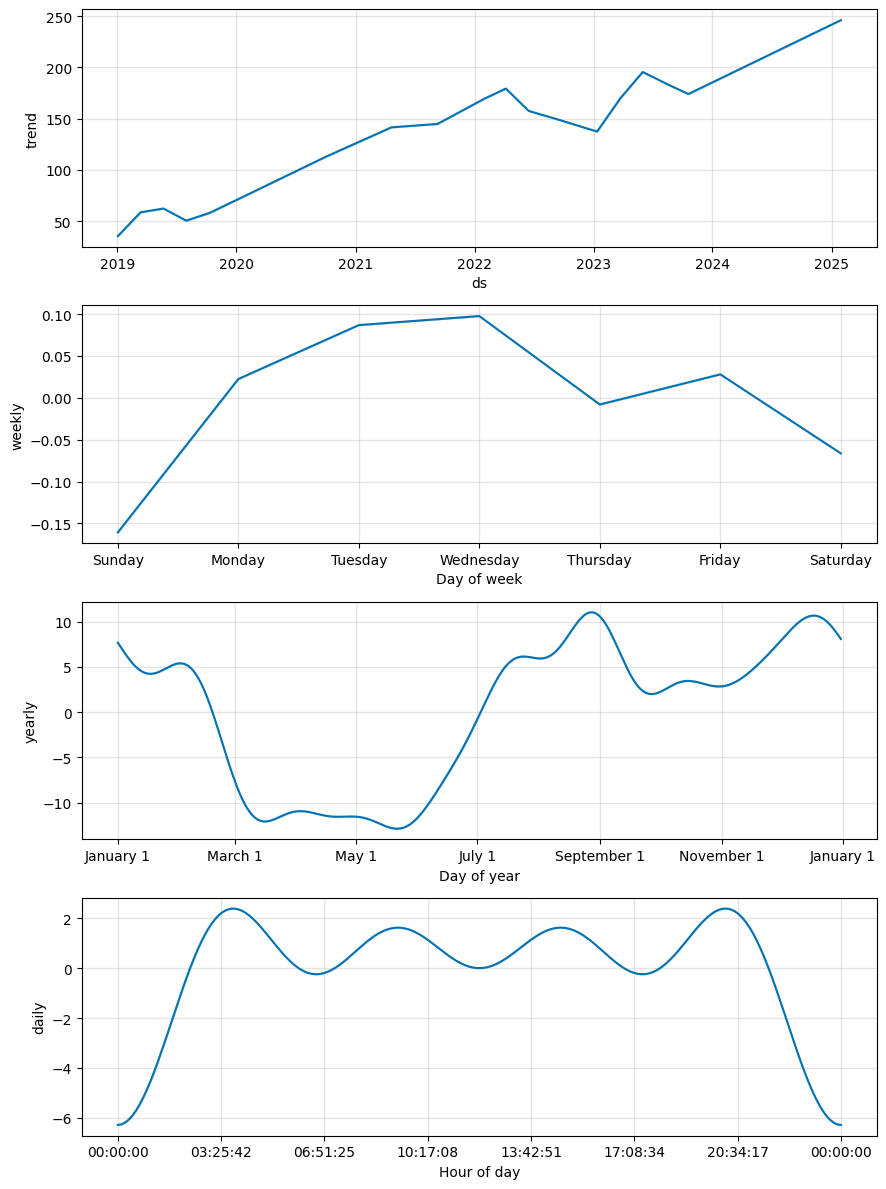

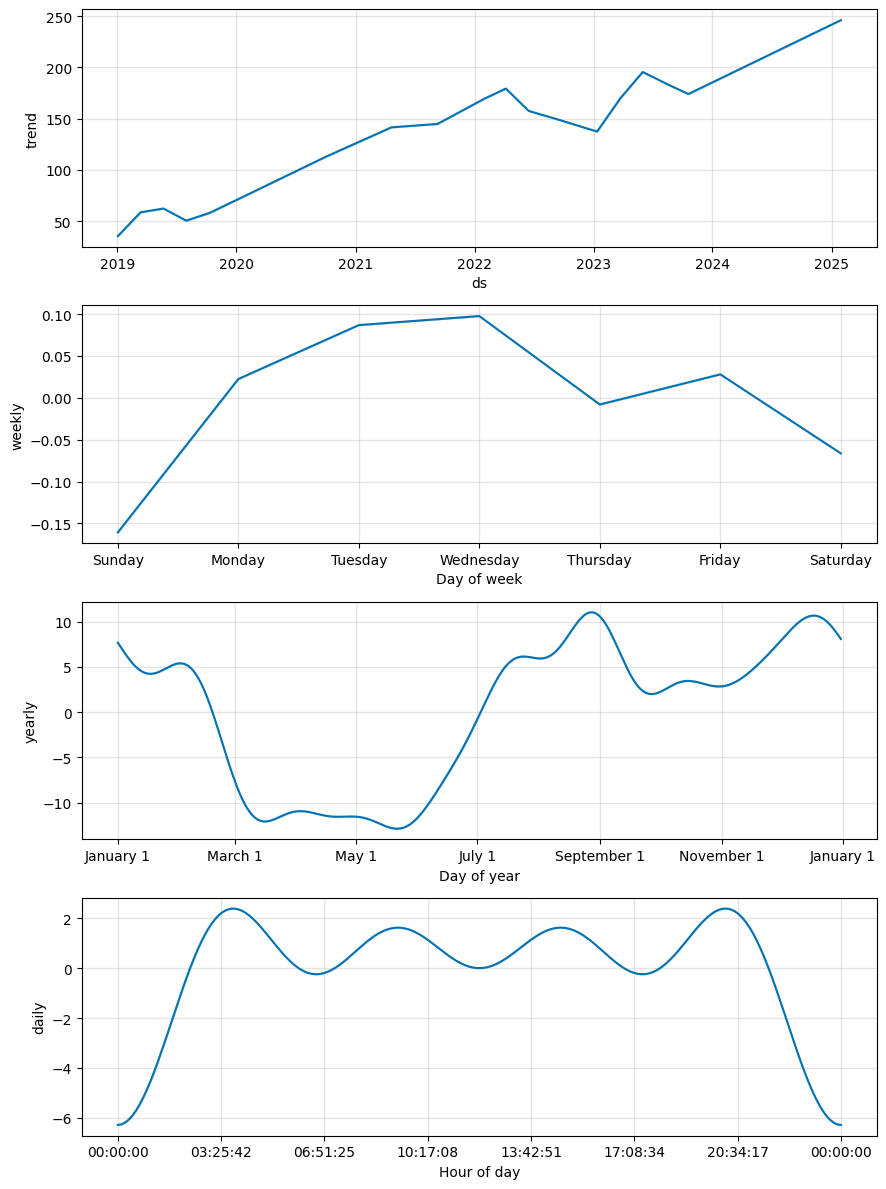

In [ ]:
results['AAPL']['model'].plot_components(results['AAPL']['forecast'])


📈 Plotting AAPL ...


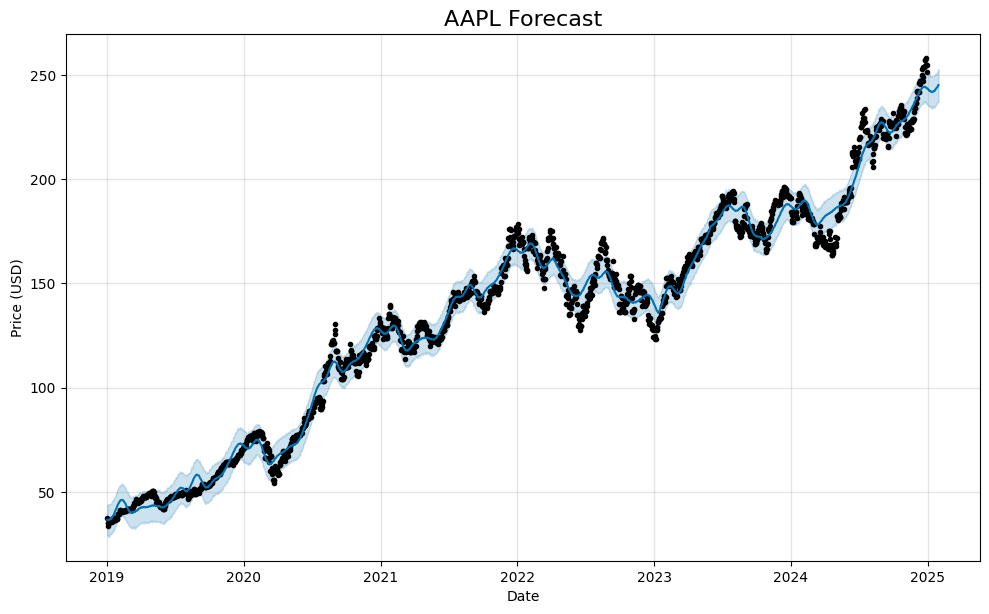

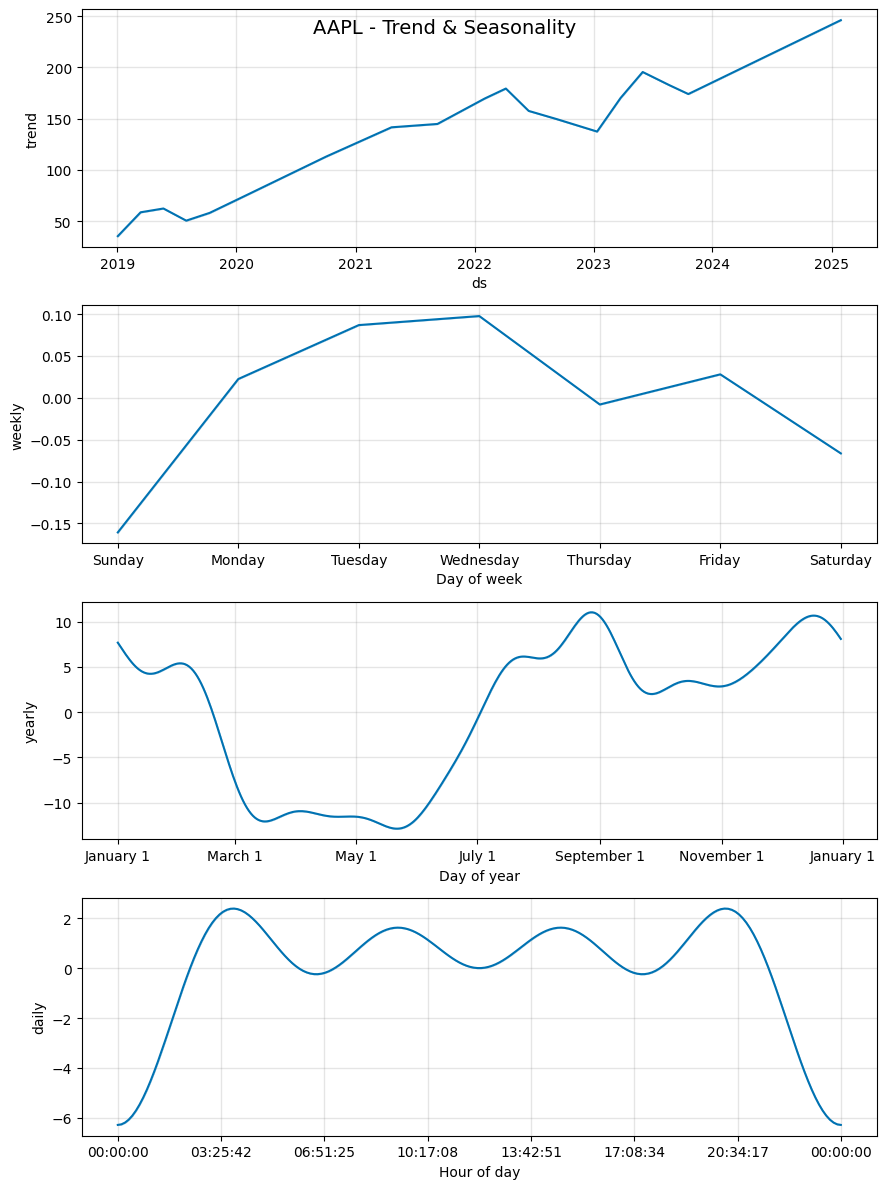

📈 Plotting AMD ...


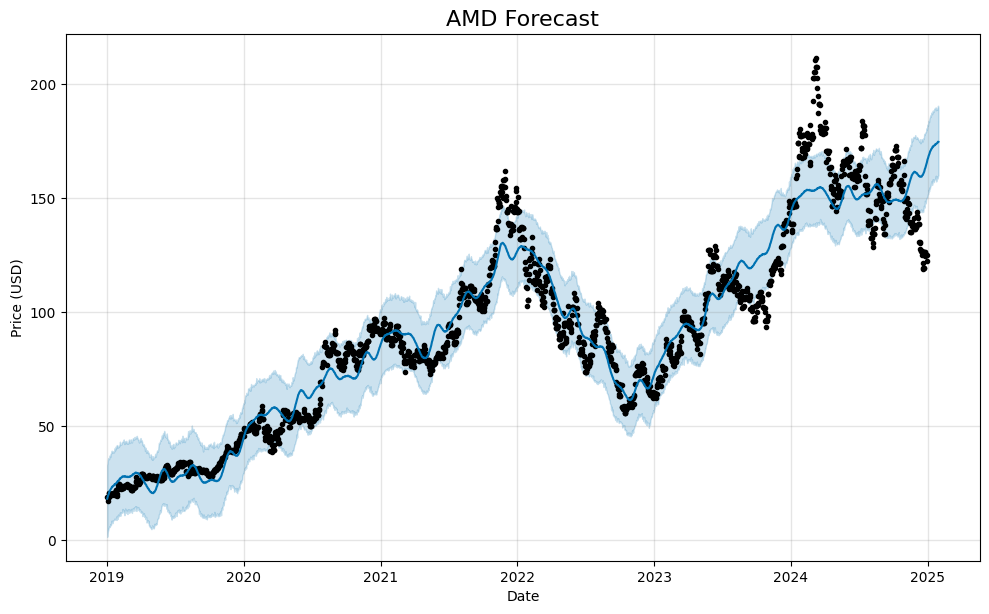

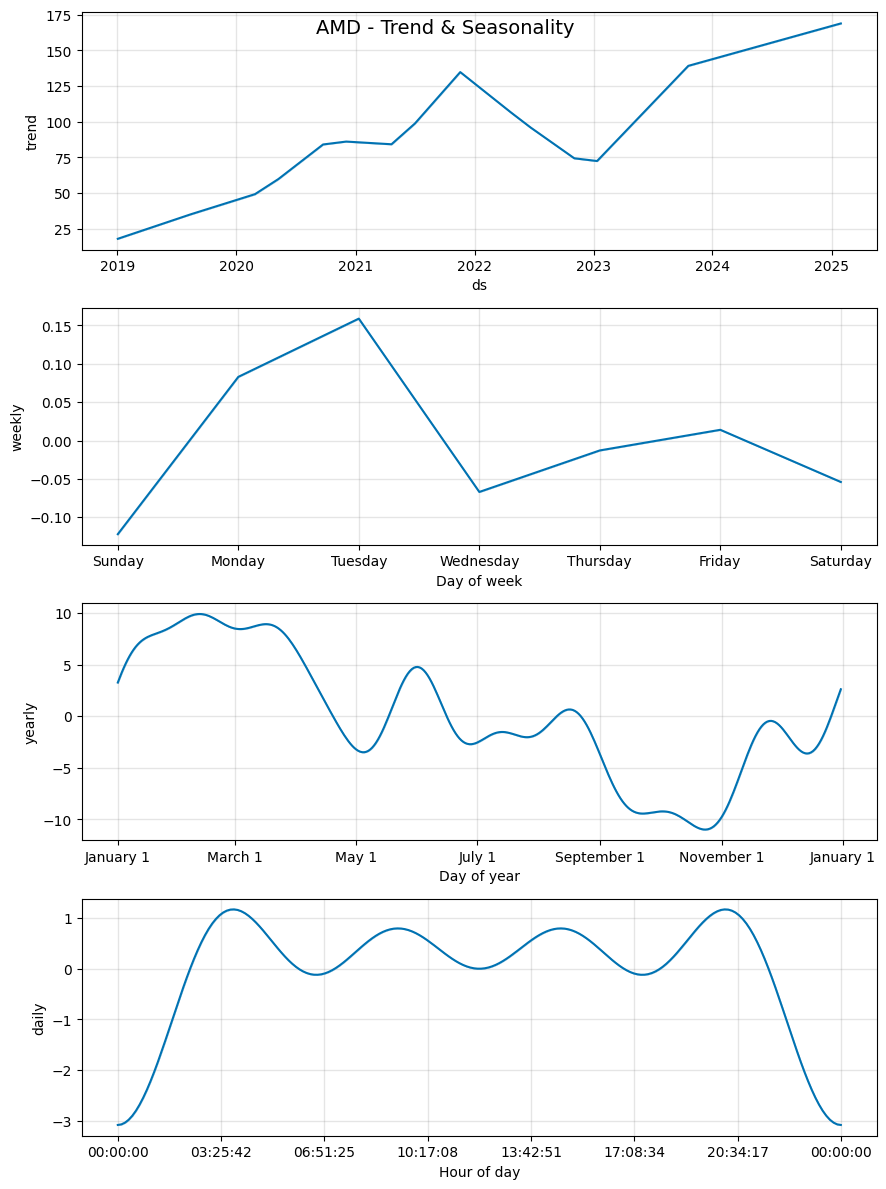

📈 Plotting APP ...


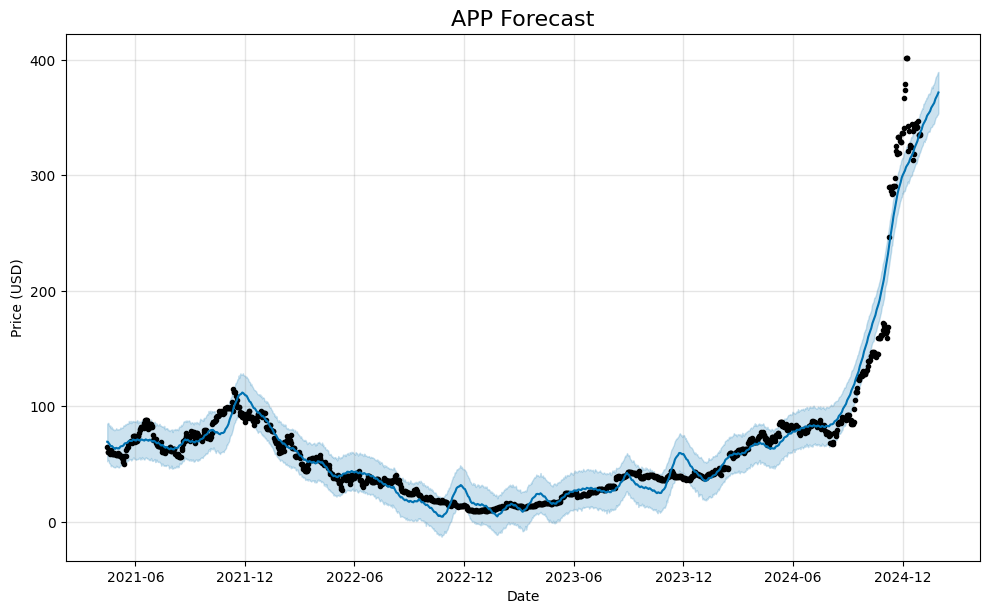

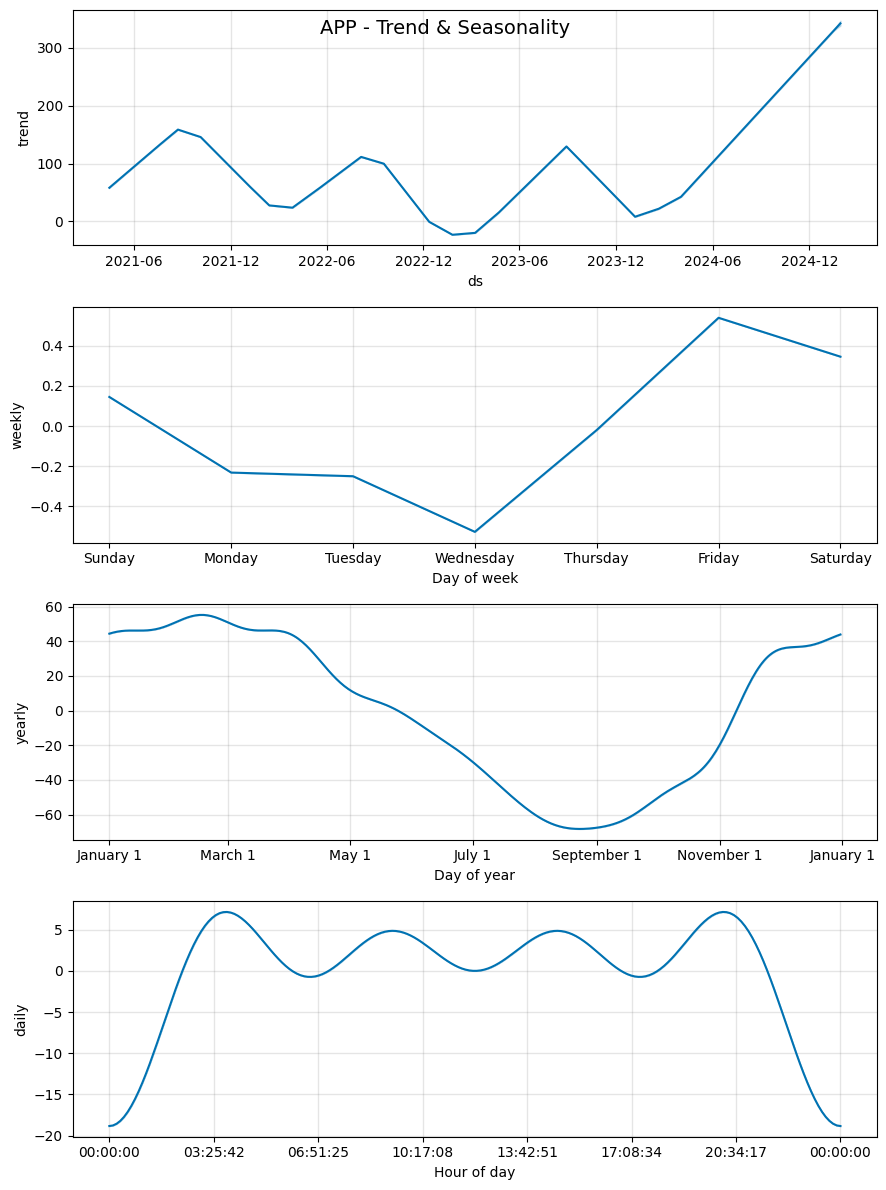

📈 Plotting AVGO ...


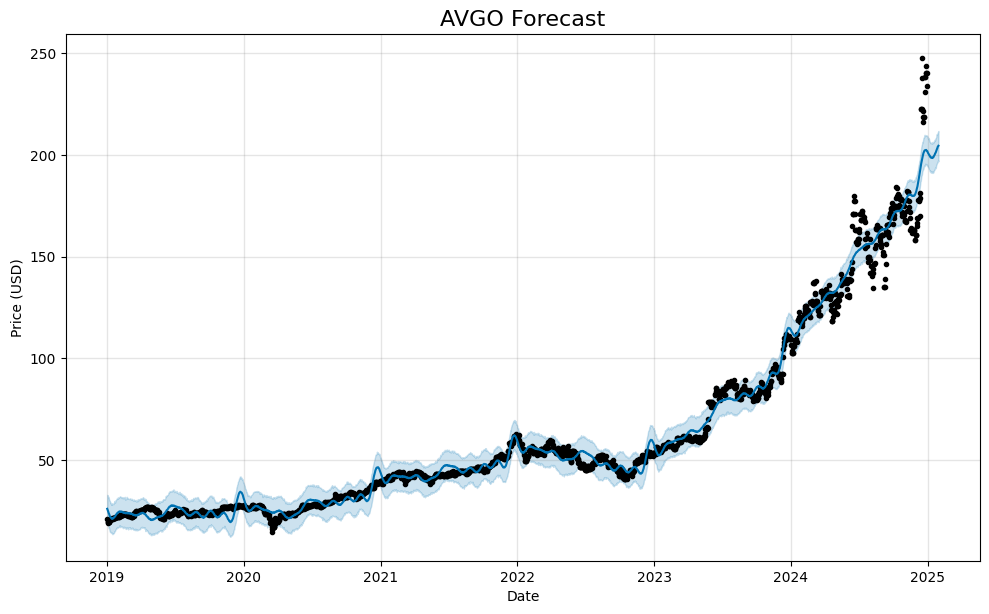

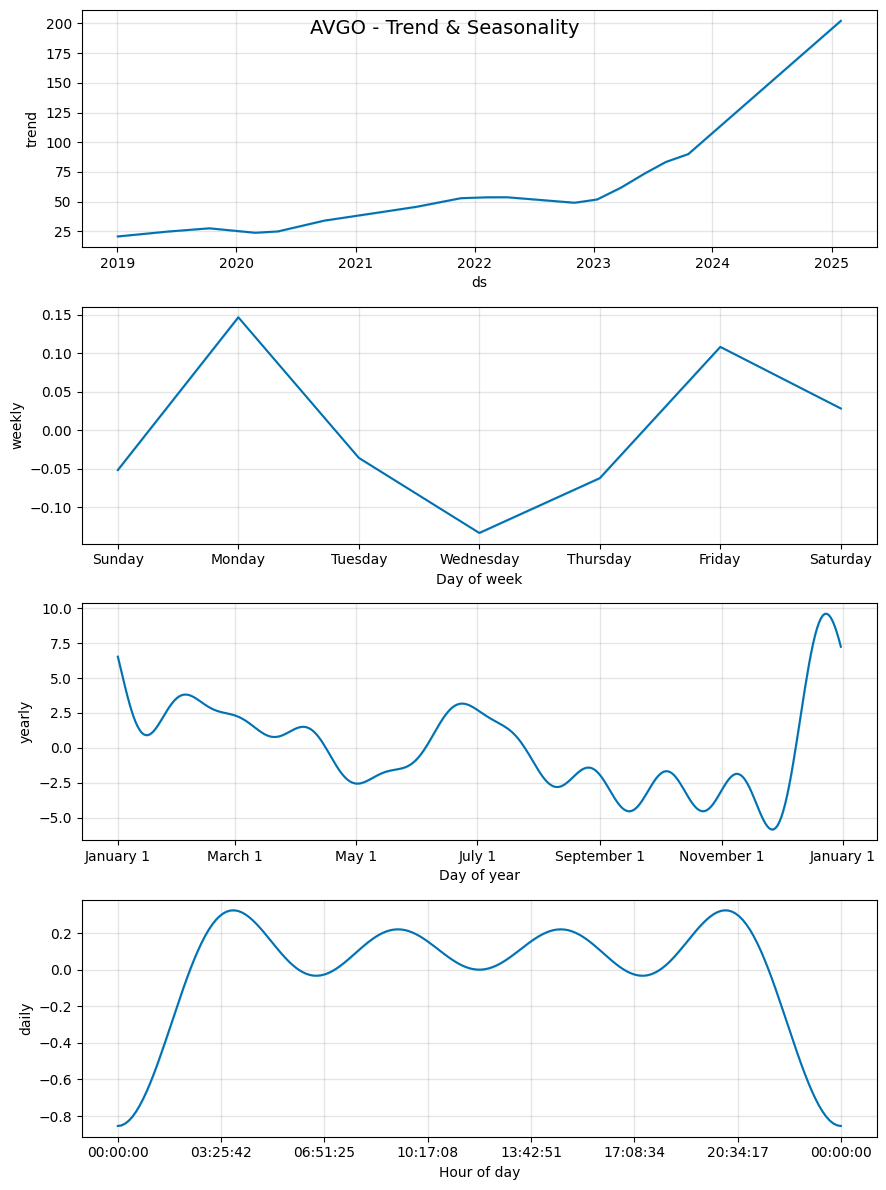

📈 Plotting GOOG ...


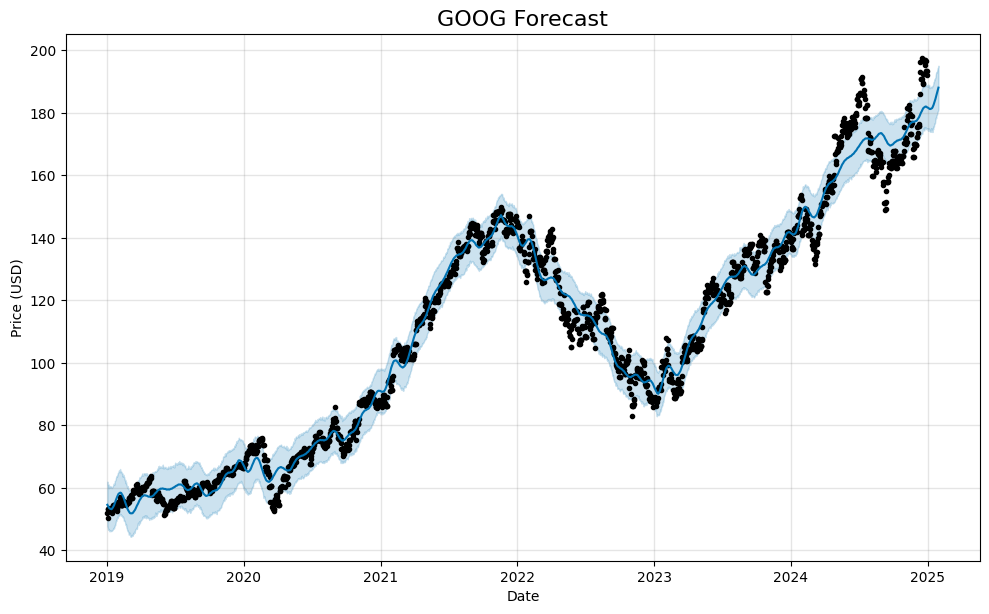

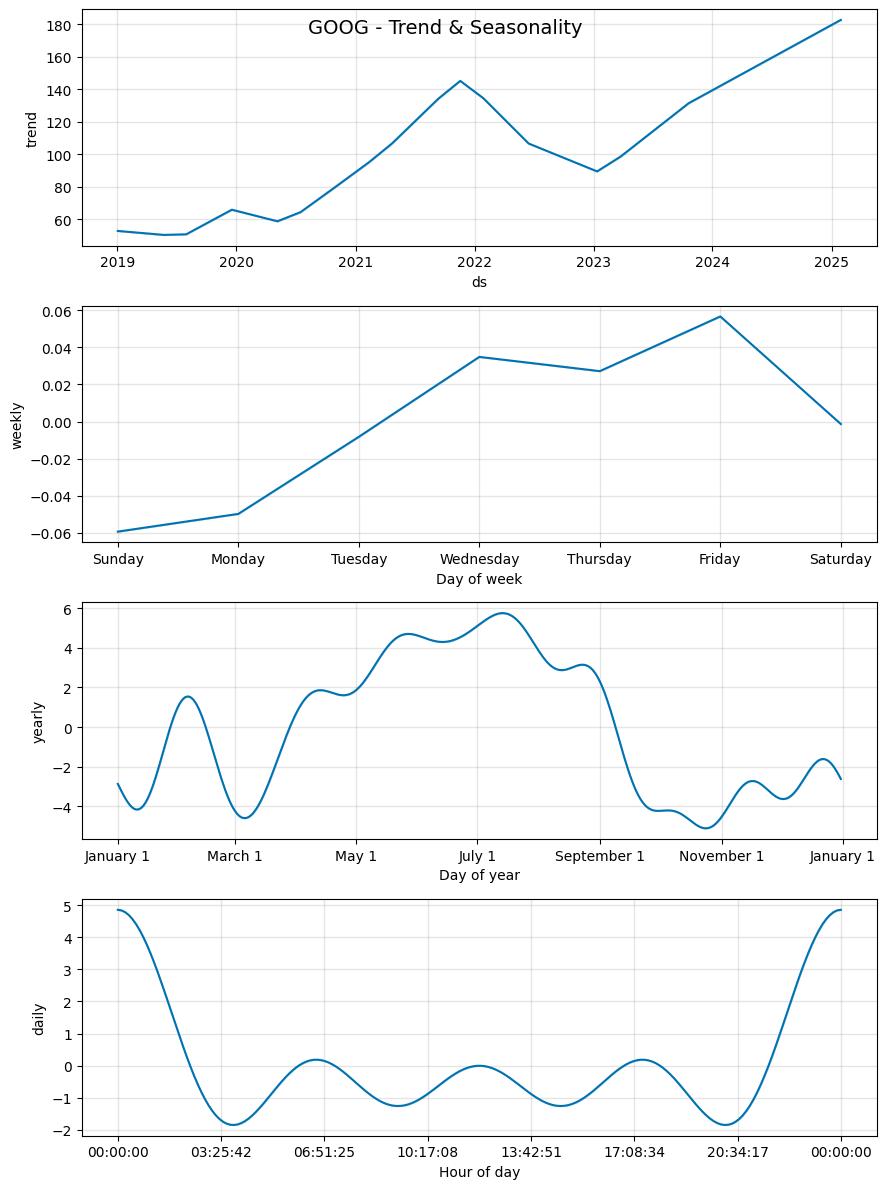

📈 Plotting GOOGL ...


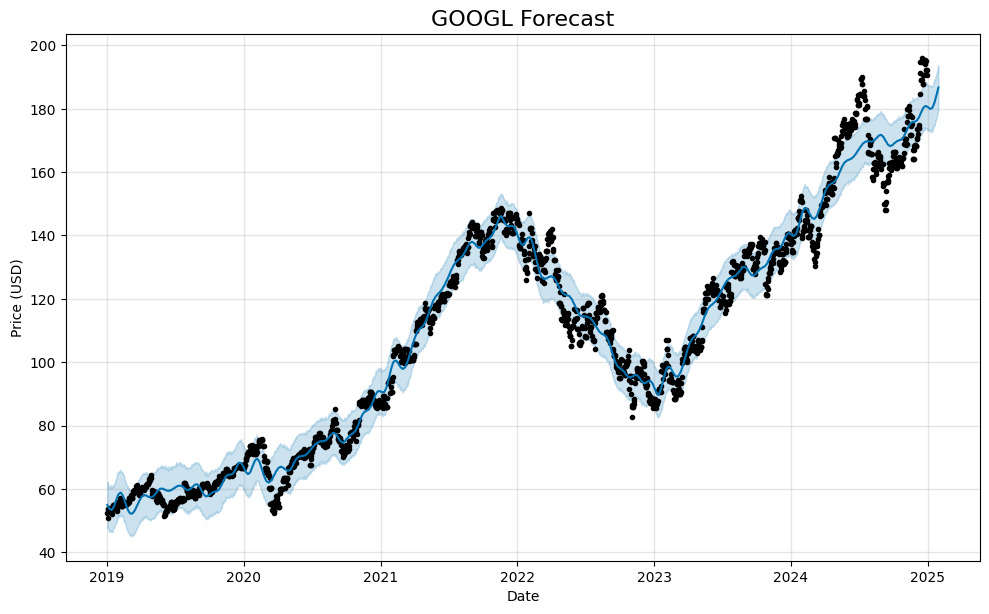

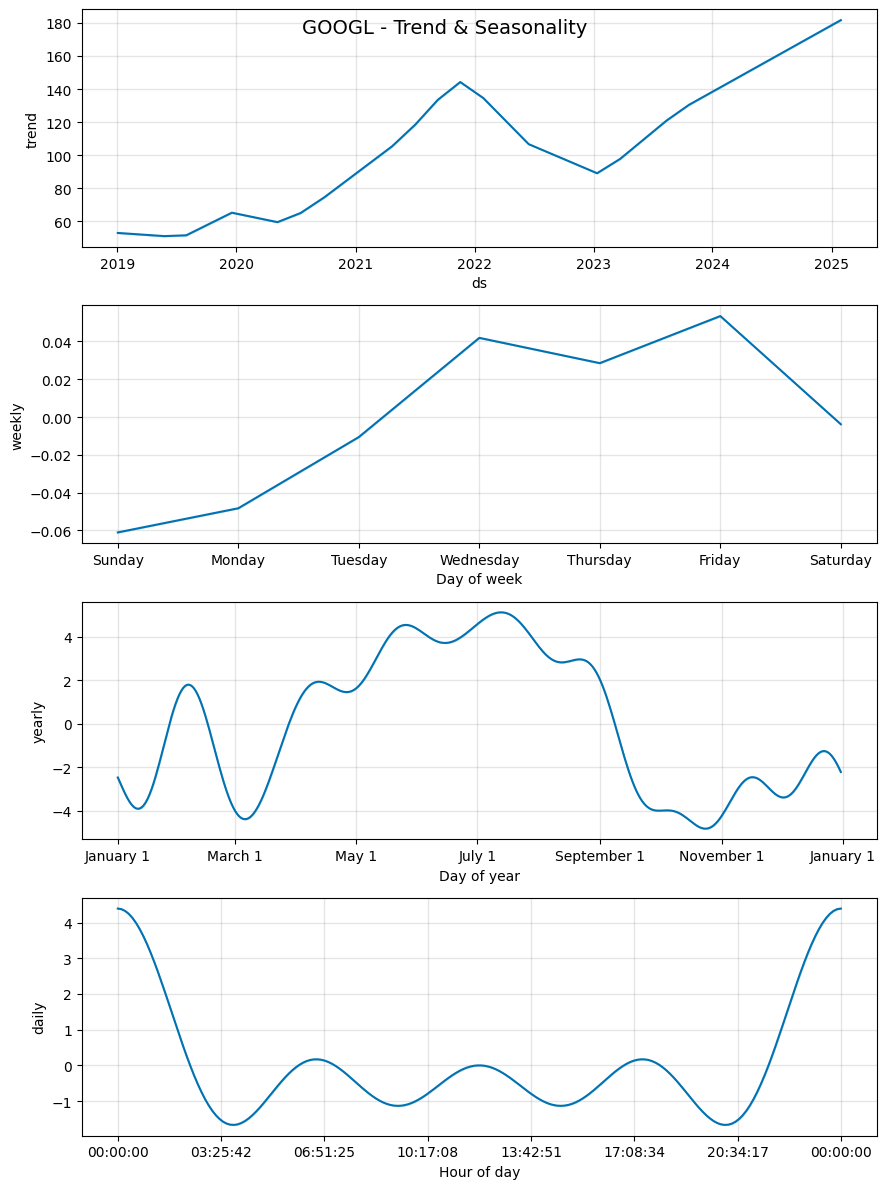

📈 Plotting META ...


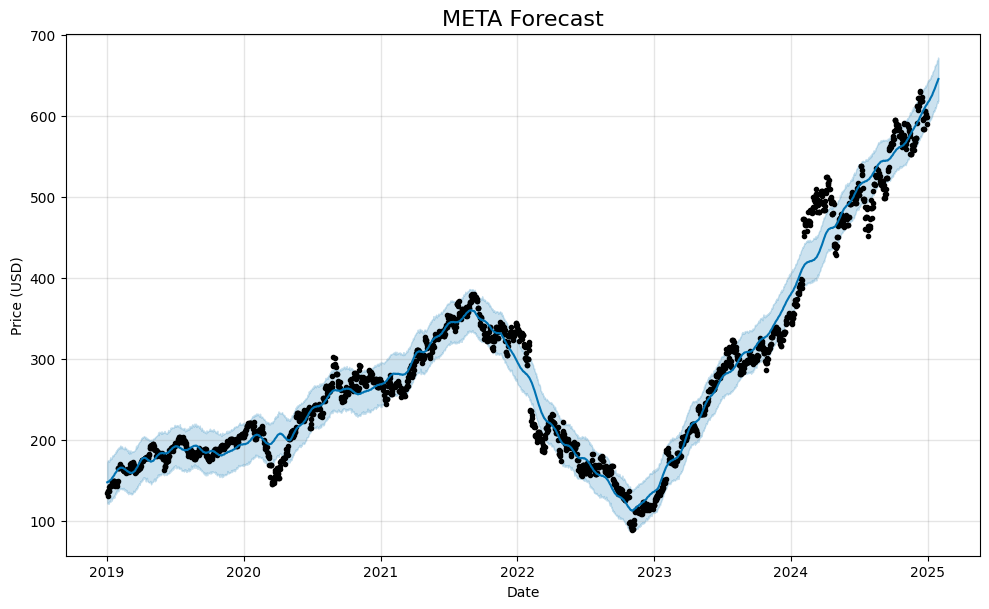

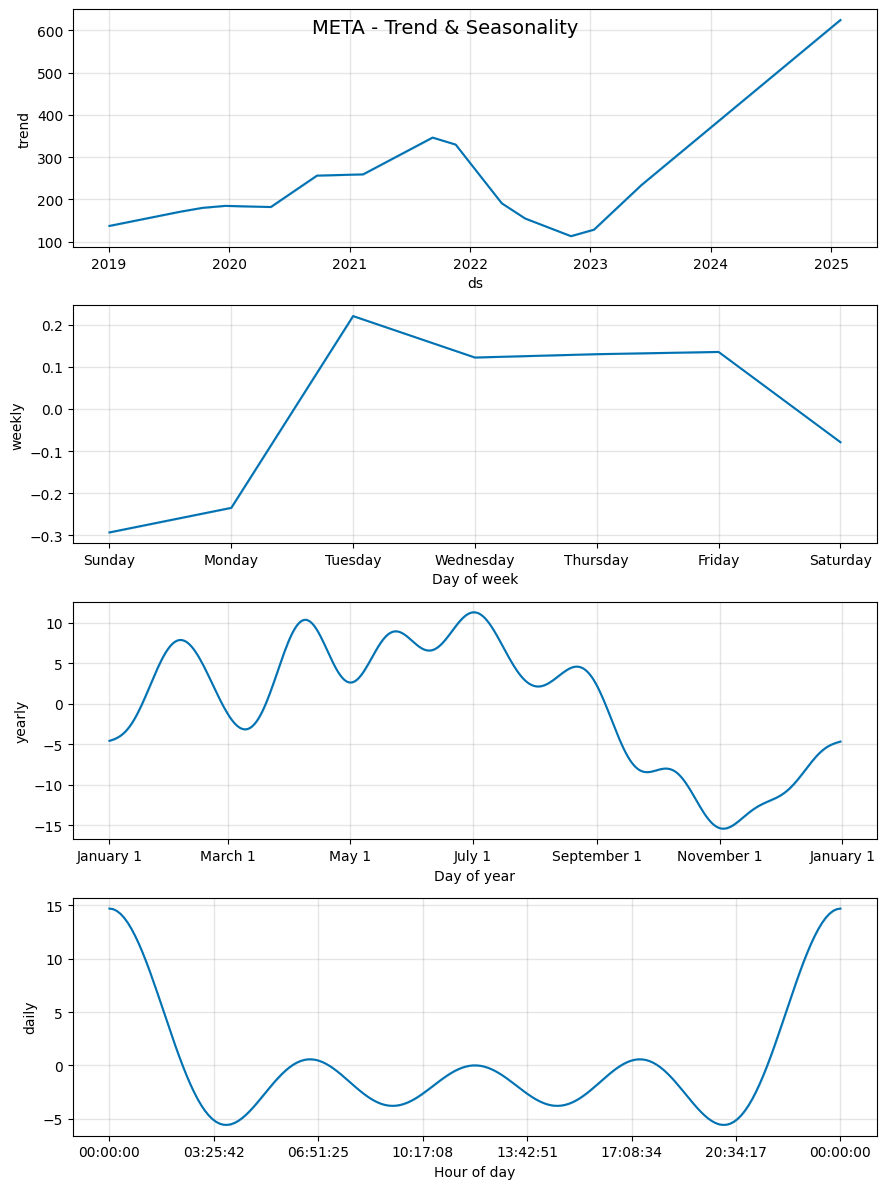

📈 Plotting MSFT ...


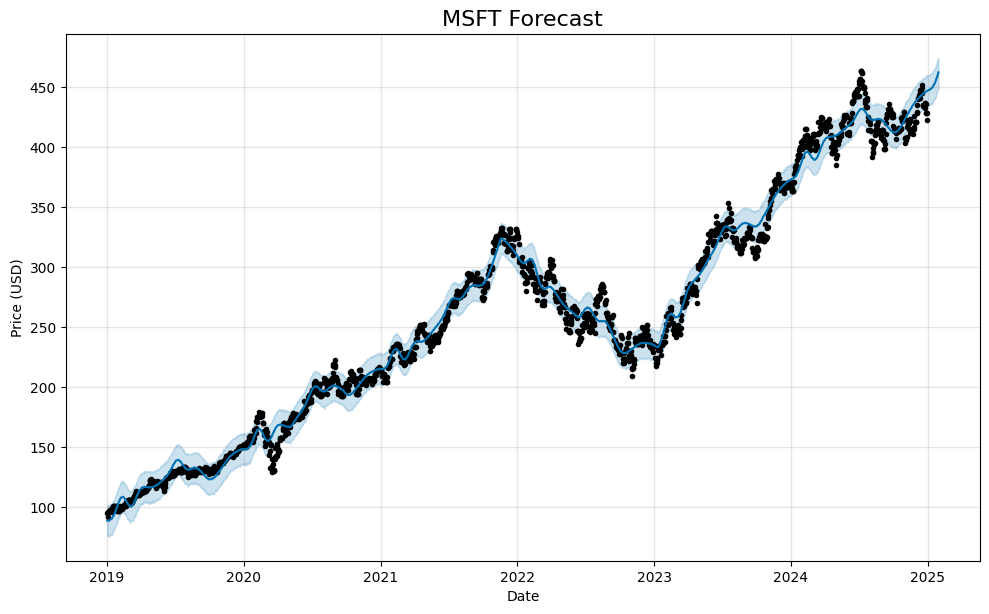

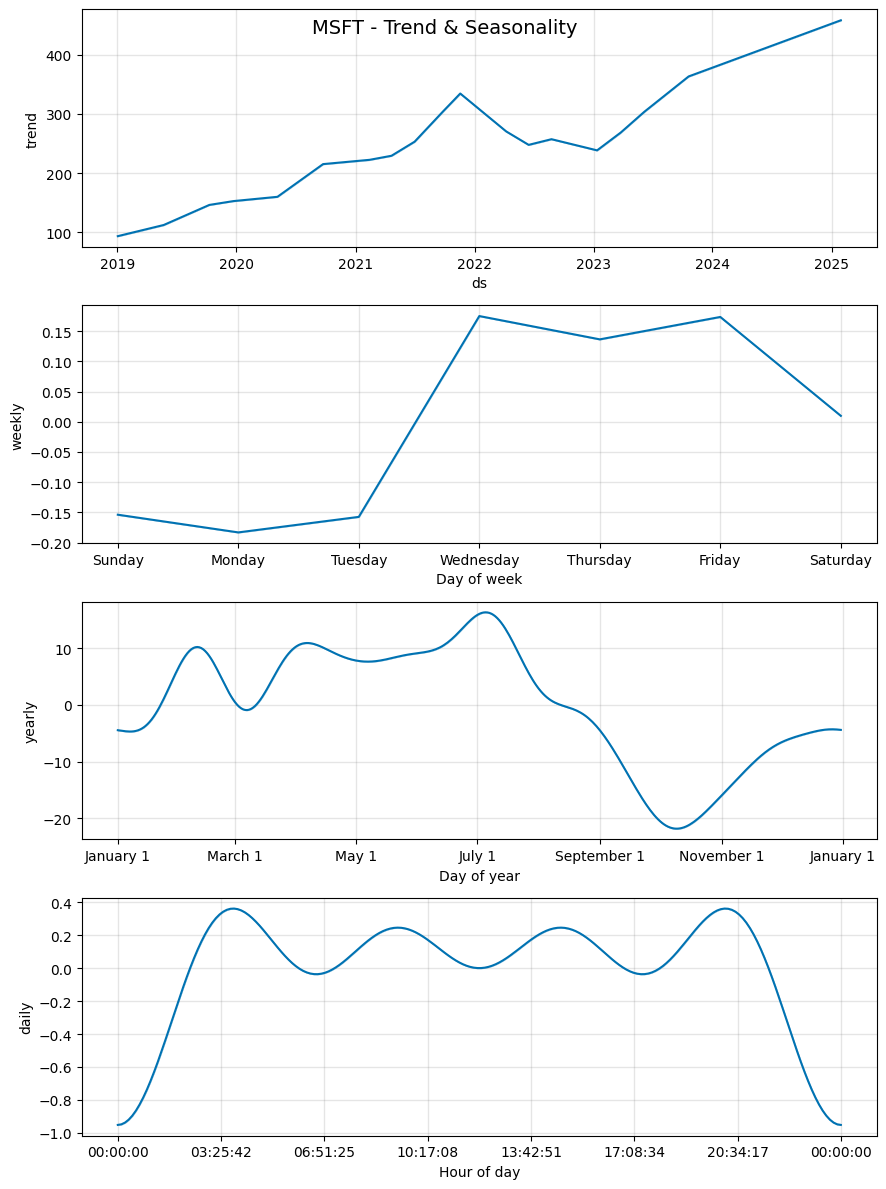

📈 Plotting NVDA ...


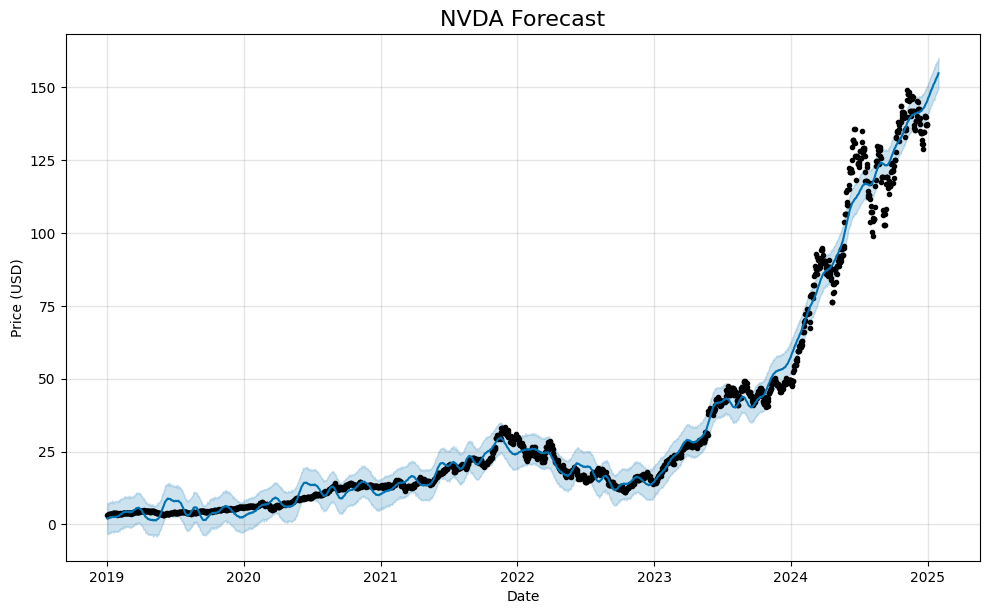

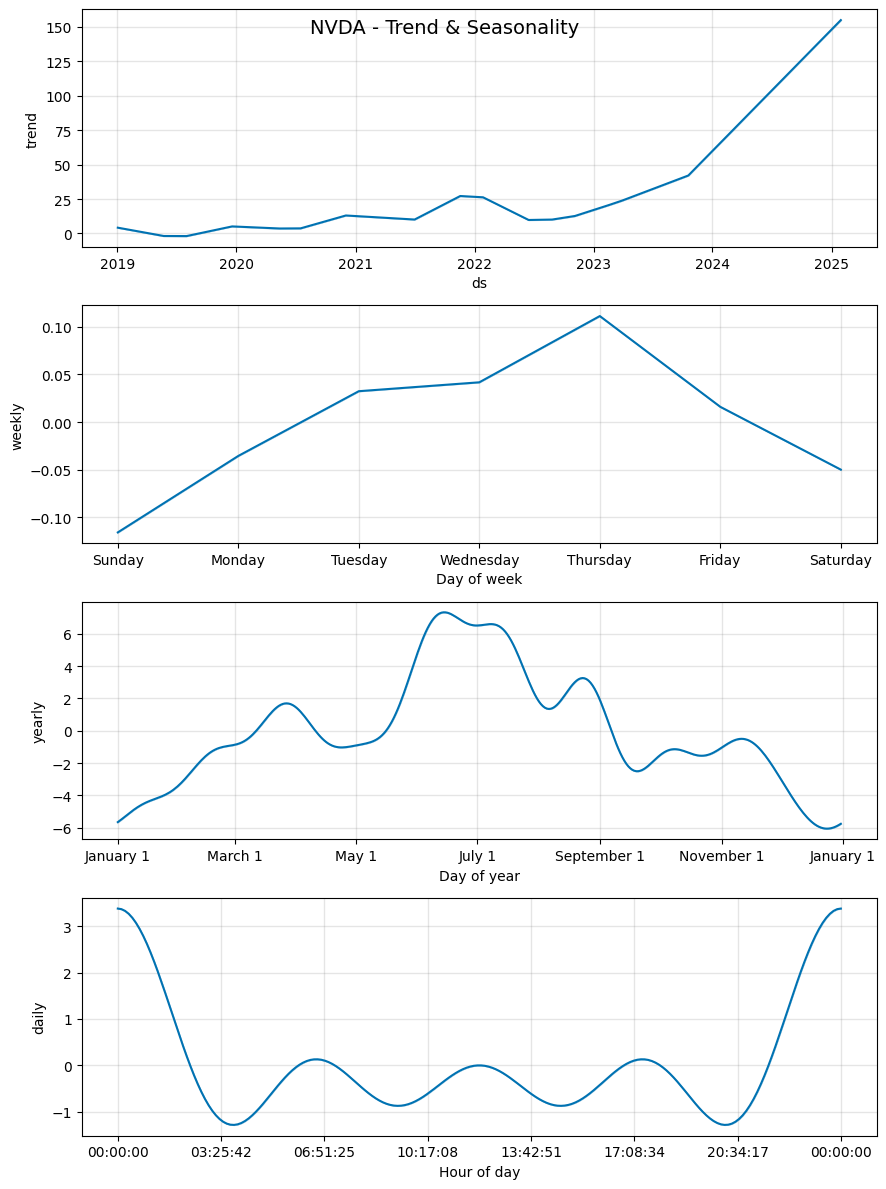

📈 Plotting PLTR ...


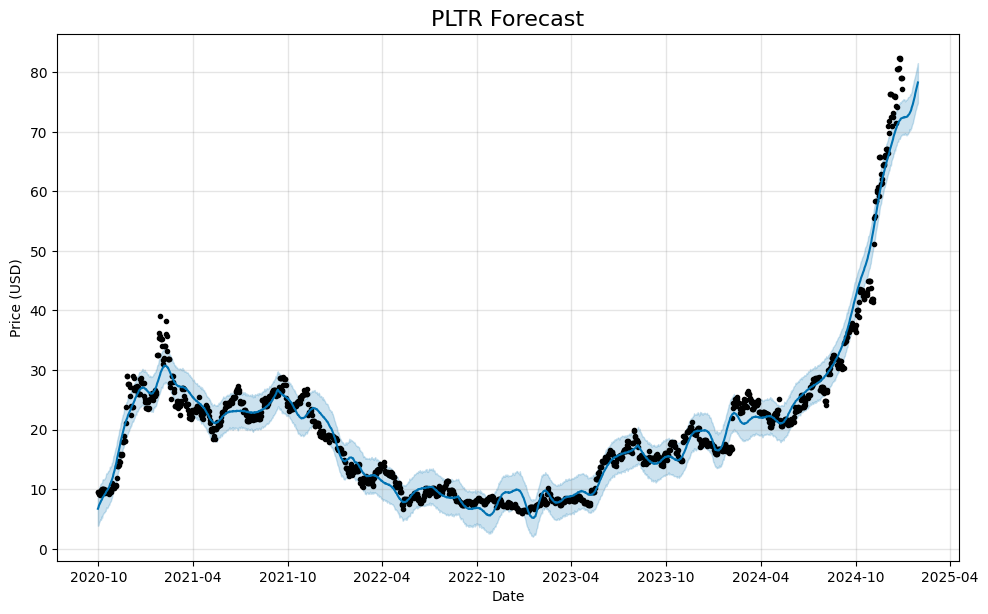

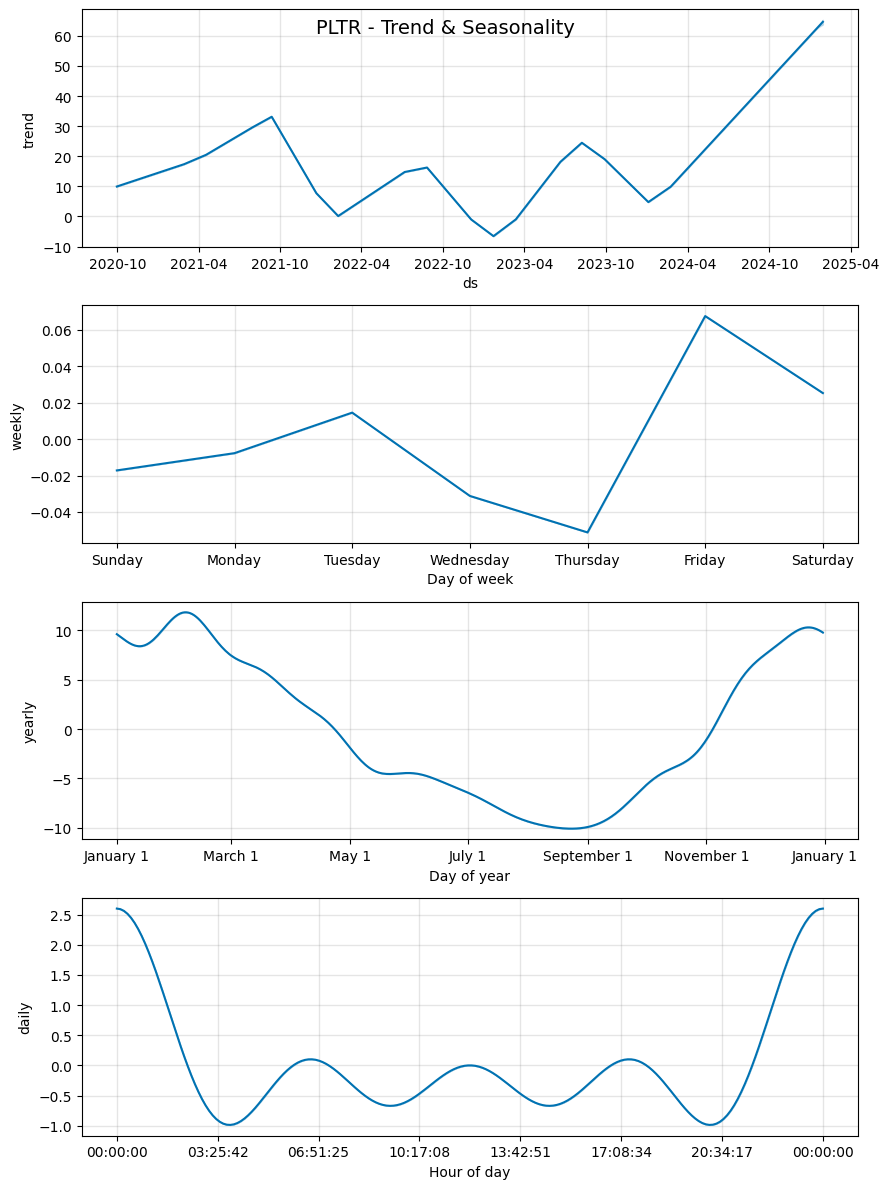

In [ ]:
import matplotlib.pyplot as plt

# วาดกราฟ Forecast ของทุกหุ้น
for ticker in results.keys():
    forecast = results[ticker]['forecast']
    model = results[ticker]['model']
    history = results[ticker]['history']

    print(f"📈 Plotting {ticker} ...")
    fig1 = model.plot(forecast)
    plt.title(f"{ticker} Forecast", fontsize=16)
    plt.xlabel("Date")
    plt.ylabel("Price (USD)")
    plt.show()

    # Components (trend + seasonality)
    fig2 = model.plot_components(forecast)
    plt.suptitle(f"{ticker} - Trend & Seasonality", fontsize=14)
    plt.show()




📊 Evaluation Metrics (Prophet):
  Ticker        MAE       RMSE   MAPE (%)        R²
0   AAPL   4.437931   5.808943   3.764934  0.988429
1    AMD   8.894849  11.970040  10.185487  0.922272
2    APP   8.007096  12.660588  16.944410  0.958989
3   AVGO   3.552052   5.624912   6.333468  0.984298
4   GOOG   4.166369   5.432446   3.957084  0.978800
5  GOOGL   4.193097   5.452534   3.990741  0.978027
6   META  14.552675  20.012341   5.517488  0.973112
7   MSFT   7.658295   9.922781   3.077609  0.989442
8   NVDA   2.741805   4.011441  15.810488  0.988279
9   PLTR   1.679864   2.274653   9.719909  0.968126


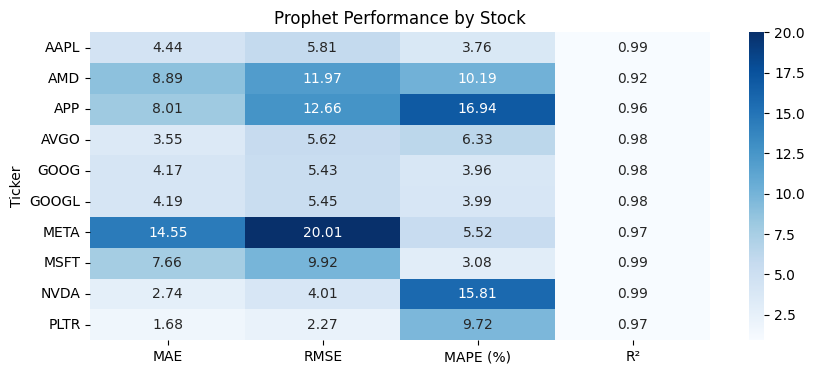

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

metrics_list = []

for ticker in results.keys():
    forecast = results[ticker]['forecast']
    history = results[ticker]['history']

    # ตัด forecast ให้ตรงกับช่วง test (จริง ๆ)
    forecast_df = forecast.set_index("ds").loc[history['ds']].reset_index()
    y_true = history['y'].values
    y_pred = forecast_df['yhat'].values

    # คำนวณ Metrics
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    r2 = r2_score(y_true, y_pred)

    metrics_list.append([ticker, mae, rmse, mape, r2])

# รวมเป็น DataFrame
metrics_df = pd.DataFrame(metrics_list, columns=["Ticker", "MAE", "RMSE", "MAPE (%)", "R²"])
print("\n📊 Evaluation Metrics (Prophet):")
print(metrics_df)

# แสดงตารางสวย ๆ
import seaborn as sns
plt.figure(figsize=(10,4))
sns.heatmap(metrics_df.set_index("Ticker")[["MAE","RMSE","MAPE (%)","R²"]], annot=True, fmt=".2f", cmap="Blues")
plt.title("Prophet Performance by Stock")
plt.show()


In [ ]:
metrics_df.to_csv("LSTM+Probhet+ForwardIn..csv", index=False)

In [ ]:
!pip install tensorflow ta
# -----------------------------------------------------------------------------
# 0) Import Libraries
# -----------------------------------------------------------------------------
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# -----------------------------------------------------------------------------
# 1) เตรียมข้อมูล
# -----------------------------------------------------------------------------
feature_cols = ['SMA_20','SMA_50','EMA_20','EMA_50',
                'BB_middle','BB_upper','BB_lower']

flat_df_scaled = flat_df_clean.copy()
scaler = StandardScaler()
flat_df_scaled[feature_cols] = scaler.fit_transform(flat_df_scaled[feature_cols])

def create_sequences(symbol_df, seq_len=30):
    X, y = [], []
    data = symbol_df[feature_cols].values
    target = symbol_df['Close_next'].values
    for i in range(len(data) - seq_len):
        X.append(data[i:i+seq_len])
        y.append(target[i+seq_len])
    return np.array(X), np.array(y)

# -----------------------------------------------------------------------------
# 2) ฟังก์ชัน Train & Evaluate LSTM
# -----------------------------------------------------------------------------
def run_lstm_for_symbol(symbol, seq_len=30, epochs=50, batch_size=32):
    df_sym = flat_df_scaled[flat_df_scaled['Symbol'] == symbol].dropna()
    if len(df_sym) < seq_len + 50:
        return None  # ข้ามถ้าข้อมูลน้อยเกินไป

    X, y = create_sequences(df_sym, seq_len=seq_len)

    # Split 70/15/15
    n = len(X)
    train_end = int(0.7*n)
    valid_end = int(0.85*n)

    X_train, y_train = X[:train_end], y[:train_end]
    X_valid, y_valid = X[train_end:valid_end], y[train_end:valid_end]
    X_test, y_test   = X[valid_end:], y[valid_end:]

    # LSTM model
    model = Sequential([
        LSTM(64, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
        Dropout(0.2),
        LSTM(32),
        Dropout(0.2),
        Dense(1)
    ])

    model.compile(optimizer='adam', loss='mse')
    model.fit(
        X_train, y_train,
        validation_data=(X_valid, y_valid),
        epochs=epochs,
        batch_size=batch_size,
        verbose=0  # ไม่ต้องแสดง progress
    )

    # Predict
    y_pred = model.predict(X_test, verbose=0).flatten()

    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)

    return {
        "Symbol": symbol,
        "MAE": mae,
        "RMSE": rmse,
        "R2": r2
    }

# -----------------------------------------------------------------------------
# 3) รันทุก Symbol
# -----------------------------------------------------------------------------
symbols = flat_df_scaled['Symbol'].unique()
results = []

for sym in symbols:
    print(f"📈 Training {sym} ...")
    res = run_lstm_for_symbol(sym, seq_len=30, epochs=50, batch_size=32)
    if res:
        results.append(res)
        print(f"✅ Done {sym} → MAE={res['MAE']:.4f}, RMSE={res['RMSE']:.4f}, R2={res['R2']:.4f}")
    else:
        print(f"⚠️ Skip {sym} (not enough data)")

# -----------------------------------------------------------------------------
# 4) Export Results
# -----------------------------------------------------------------------------
results_df = pd.DataFrame(results).round(4)
results_df.to_csv("lstm_all_symbols.csv", index=False, encoding="utf-8-sig")
results_df.to_excel("lstm_all_symbols.xlsx", index=False)

print("✅ Export เสร็จสิ้น → lstm_all_symbols.csv / .xlsx")



  Preparing metadata (setup.py) ... done
  Created wheel for ta: filename=ta-0.11.0-py3-none-any.whl size=29412 sha256=52eb067ed9d43eb0d6e010aaaba2122dbcf747795b00c4090ef33d53ccf9f3d6
  Stored in directory: /root/.cache/pip/wheels/5c/a1/5f/c6b85a7d9452057be4ce68a8e45d77ba34234a6d46581777c6
Successfully built ta


NameError: name 'flat_df_clean' is not defined

In [ ]:
!pip install ta

In [ ]:
# ================================
# 3. FEATURE ENGINEERING (Indicators)
# ================================
flat_list = []
for ticker in tickers:
    df = data[ticker].copy()
    df["Symbol"] = ticker
    df["MA10"] = talib.SMA(df["Close"], timeperiod=10)
    df["MA30"] = talib.SMA(df["Close"], timeperiod=30)
    df["RSI"]  = talib.RSI(df["Close"], timeperiod=14)
    macd, macdsignal, macdhist = talib.MACD(df["Close"], fastperiod=12, slowperiod=26, signalperiod=9)
    df["MACD"] = macd
    df["MACD_signal"] = macdsignal
    flat_list.append(df)

flat_df = pd.concat(flat_list)
flat_df = flat_df.dropna().reset_index()

# ================================
# 4. CLEAN + SCALING
# ================================
feature_cols = ["Open", "High", "Low", "Close", "Volume", "MA10", "MA30", "RSI", "MACD", "MACD_signal"]
flat_df_clean = flat_df.copy()
scaler = StandardScaler()
flat_df_clean[feature_cols] = scaler.fit_transform(flat_df_clean[feature_cols])

# ================================
# 5. FUNCTION: CREATE SEQUENCES
# ================================
def create_sequences(symbol_df, seq_len=30):
    X, y = [], []
    data = symbol_df[feature_cols].values
    target = symbol_df["Close"].values
    for i in range(len(data) - seq_len):
        X.append(data[i:i+seq_len])
        y.append(target[i+seq_len])
    return np.array(X), np.array(y)

# ================================
# 6. TRAIN LSTM LOOP FOR EACH STOCK
# ================================
results = []
seq_len = 30

for ticker in tickers:
    symbol_df = flat_df_clean[flat_df_clean["Symbol"] == ticker].reset_index(drop=True)
    X, y = create_sequences(symbol_df, seq_len=seq_len)

    # Train/Test Split (70/30)
    split = int(len(X) * 0.7)
    X_train, X_test = X[:split], X[split:]
    y_train, y_test = y[:split], y[split:]

    # LSTM Model
    model = Sequential([
        LSTM(64, return_sequences=True, input_shape=(seq_len, len(feature_cols))),
        Dropout(0.2),
        LSTM(32),
        Dense(1)
    ])
    model.compile(optimizer="adam", loss="mse")
    model.fit(X_train, y_train, epochs=10, batch_size=32, verbose=0)

    # Predict
    y_pred = model.predict(X_test)

    # Metrics
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae  = mean_absolute_error(y_test, y_pred)
    r2   = r2_score(y_test, y_pred)

    results.append([ticker, rmse, mae, r2])

# ================================
# 7. EXPORT RESULTS
# ================================
results_df = pd.DataFrame(results, columns=["Symbol", "RMSE", "MAE", "R2"])
results_df = results_df.round(4)
results_df.to_csv("lstm_results.csv", index=False)

print("✅ Training Complete. Results saved to lstm_results.csv")
print(results_df)